In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy import stats

# Features

In [2]:
# features used to select subset of problem instances
maskFeatures = ['fixedDig_num', 'fixedDig_mean',
       'fixedDig_CV', 'fixedDig_min', 'fixedDig_max', 'fixedDig_entropy',
       'counts_mean', 'counts_naked1', 'counts_naked2', 'counts_naked3',
       'counts_CV', 'counts_min', 'counts_max', 'counts_entropy', 'value_mean',
       'value_CV', 'value_min', 'value_max', 'value_entropy', 'emptySets']


Loading feature space

In [3]:
fspace = pd.read_pickle('./Data/featureSpace1000.pkl')
fspace.sort_index(inplace=True)
fspace.rename(columns={'PC1':'PC1_3m','PC2':'PC2_3m'},inplace=True) #PC from sample1000.pkl - for all data
fspace.drop(columns=['puzzlesF','N'], inplace=True)
fspace['source'] = fspace['source'].apply(str)

# summary stats - then dropping variables that are the same
fs_summary = fspace.iloc[:,4:].describe().T.drop(columns='count')
fs_summary['CV'] = fspace.iloc[:,4:].apply(stats.variation)

fs_summary[fs_summary['std'] == 0].index
fspace.drop(columns=fs_summary[fs_summary['std'] == 0].index, inplace=True)
fs_summary.drop(index=fs_summary[fs_summary['std'] == 0].index, inplace=True)


Calculating Principal Components using puzzle mask features and full set of features. 

In [4]:
featuresSTD_full = StandardScaler().fit_transform(fspace.iloc[:,4:].values)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(featuresSTD_full)
fspace[['PC1_full','PC2_full']] = principalComponents

del(featuresSTD_full,pca,principalComponents)

featuresSTD = StandardScaler().fit_transform(fspace.loc[:,maskFeatures].values)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(featuresSTD)
fspace[['PC1_mask','PC2_mask']] = principalComponents

del(featuresSTD,pca,principalComponents)

PCtypes = ['PC1_3m','PC1_mask','PC1_full','PC2_3m','PC2_mask','PC2_full']

# Results

In [5]:
RR = pd.read_pickle('./Data/Performance Data/RR_perf.pkl').drop(columns=['puzzlesF','solnInit','PC1', 'PC2'])
SA = pd.read_pickle('./Data/Performance Data/SA_perf.pkl').drop(columns=['puzzlesF','solnInit','PC1', 'PC2'])
RVNS = pd.read_pickle('./Data/Performance Data/RVNS_perf.pkl').drop(columns=['puzzlesF','solnInit','PC1', 'PC2'])
SD = pd.read_pickle('./Data/Performance Data/SD_perf.pkl').drop(columns=['puzzlesF','solnInit','PC1', 'PC2'])


In [6]:
print('Number of instances solution found')
print('RR',[len(x) for x in RR.RR_sols].count(2))
print('SA',[len(x) for x in SA.SA_sols].count(2))
print('RVNS',[len(x) for x in RVNS.RVNS_sols].count(2))
print('SD',[len(x) for x in SD.SD_sols].count(2))

Number of instances solution found
RR 442
SA 438
RVNS 345
SD 326


In [7]:
SA.sort_index(inplace=True)
RR.sort_index(inplace=True)
RVNS.sort_index(inplace=True)
SD.sort_index(inplace=True)
fspace.sort_index(inplace=True)

In [8]:
initResults = pd.concat([SA,RR.iloc[:,2:],SD.iloc[:,2:],RVNS.iloc[:,2:]], axis=1)
initResults = pd.concat([fspace.loc[:,PCtypes],initResults], axis=1)
initResults.drop(columns=['RR_sols','SA_sols','RVNS_sols','SD_sols'],inplace=True)

resultsSummary = pd.DataFrame()
resultsSummary[['source']+PCtypes] = initResults[['source']+PCtypes]

## Obj Value

In [9]:
# minimum, mean and median objective value across the 20 runs
for a in ['SA','RR','RVNS','SD']:
    resultsSummary[a+'_minobj'] = initResults[a+'_obj'].apply(min)
    resultsSummary[a+'_meanobj'] = initResults[a+'_obj'].apply(np.mean)
    resultsSummary[a+'_medobj'] = initResults[a+'_obj'].apply(np.median)

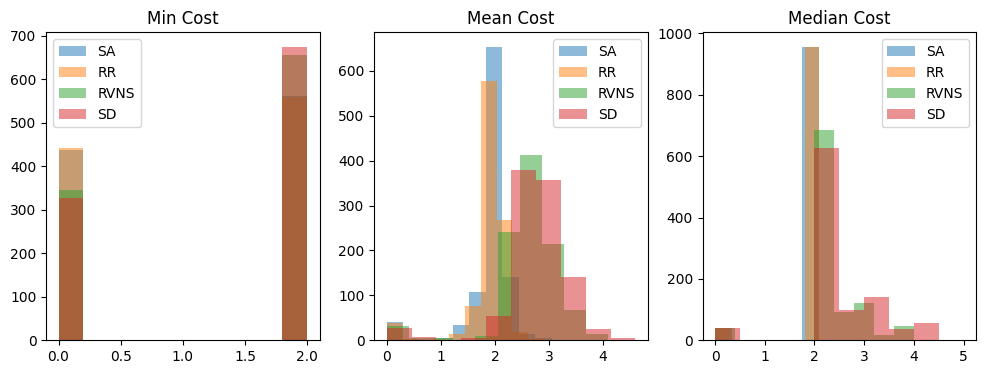

In [10]:
# Obj Value - histograms
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
for a in ['SA','RR','RVNS','SD']:
    plt.hist(a+'_minobj',alpha=0.5, label=a, data=resultsSummary)
plt.legend()
plt.title('Min Cost')

plt.subplot(1,3,2)
for a in ['SA','RR','RVNS','SD']:
    plt.hist(a+'_meanobj',alpha=0.5, label=a, data=resultsSummary)
plt.legend()
plt.title('Mean Cost')

plt.subplot(1,3,3)
for a in ['SA','RR','RVNS','SD']:
    plt.hist(a+'_medobj',alpha=0.5, label=a, data=resultsSummary)
plt.legend()
plt.title('Median Cost')

plt.show()

## Success Rates

The success rate for a given algorithm and a given problem instance, SR is the proportion of runs that a solution with cost 0 is found.

In [11]:
for a in ['SA','RR','RVNS','SD']:
    resultsSummary[a+'_SR'] = initResults[a+'_obj'].apply(lambda x: len([i for i in x if i==0])/20)


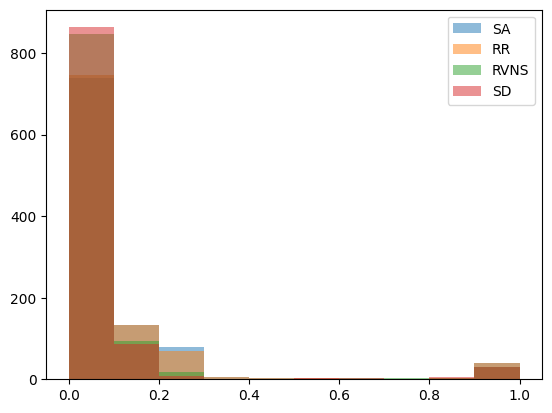

In [12]:
# SR histograms
for a in ['SA','RR','RVNS','SD']:
    plt.hist(a+'_SR',alpha=0.5, label=a, data=resultsSummary)
plt.legend()

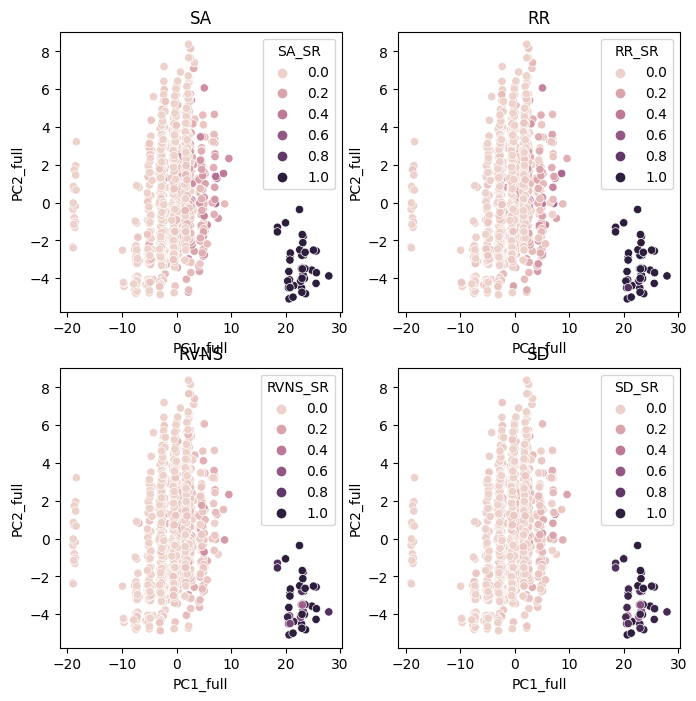

In [13]:
# SR scatterplots
pltC = 'full'
plt.figure(figsize = (8,8))

i=1
for a in ['SA','RR','RVNS','SD']:
    plt.subplot(2,2,i)
    sns.scatterplot(x='PC1_'+pltC,y='PC2_'+pltC,hue=a+'_SR',data=resultsSummary)
    plt.title(a)
    i+=1

## Cost Time

For a given algorithm, problem instance and run, the **cost-time** is 

$$c_{\text{best}} + \frac{i}{maxIts}, $$
 
where $c_{\text{best}}$ is the lowest cost achieved during a run, and $i$ is the earliest iteration in which $c_{\text{best}}$ is achieved.

In [14]:
def costTime(cost,its):
    return [cost[i] + its[i]/500000 for i in range(20)]


In [15]:
for a in ['SA','RR','RVNS','SD']:
    initResults[a+'_CT'] = initResults.apply(lambda x: costTime(x[a+'_obj'],x[a+'_bestIts']),axis=1)

# minimum, mean and median cost-time across the 20 runs
for a in ['SA','RR','RVNS','SD']:
    resultsSummary[a+'_minCT'] = initResults[a+'_CT'].apply(min)
    resultsSummary[a+'_meanCT'] = initResults[a+'_CT'].apply(np.mean)
    resultsSummary[a+'_medCT'] = initResults[a+'_CT'].apply(np.median)

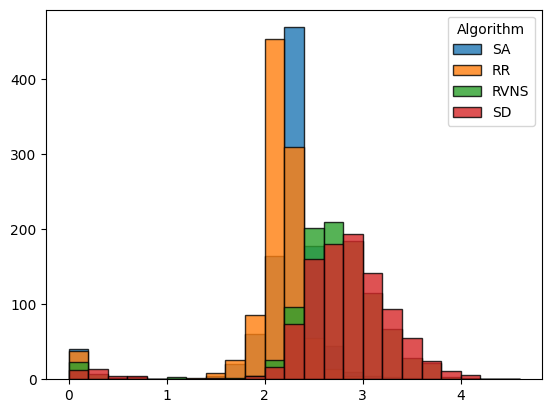

In [16]:
# meanCT histograms
for a in ['SA','RR','RVNS','SD']:
    plt.hist(a+'_meanCT',bins=np.arange(0,4.7,0.2),
             edgecolor='black',alpha=0.8, 
             label=a, 
             data=resultsSummary)
    
plt.legend(title="Algorithm")

## Matilda Input Files

Creating .csv files used as input for MATILDA. 

In [17]:
pd.to_pickle(resultsSummary,'./Data/Performance Data/resultsSummary.pkl')

In [18]:
SR_perf = resultsSummary.loc[:,['SA_SR', 'RR_SR', 'RVNS_SR', 'SD_SR']]
SR_perf.rename(columns=lambda x: 'algo_'+x, inplace=True)

InputSR = fspace.drop(columns=PCtypes)
InputSR.rename(
    columns= lambda x:'Source' if x=='source' else ('instances' if x=='puzzles' else 'feature_'+x),
    inplace=True)

InputSR = InputSR.join(SR_perf)
    
#InputSR.to_csv('./Data/Matilda Input/SR data.csv',index=False)

In [19]:
CT_perf = resultsSummary.loc[:,['SA_meanCT', 'RR_meanCT', 'RVNS_meanCT', 'SD_meanCT']]
CT_perf.rename(columns=lambda x: 'algo_'+x, inplace=True)

InputCT = fspace.drop(columns=PCtypes)
InputCT.rename(
    columns= lambda x:'Source' if x=='source' else ('instances' if x=='puzzles' else 'feature_'+x),
    inplace=True)

InputCT = InputCT.join(CT_perf)
    
#InputCT.to_csv('./Data/Matilda Input/CT data.csv',index=False)